# Data cleaning and preparation
Before jumping into the EDA (exploratory data analysis), we need to get our data cleaned and ready.

## Where is the data from?
This project uses data that has been scraped from Board Game Geek (https://boardgamegeek.com) and made available on Kaggle.

**Source** [Board Game Reviews - Jan 2025] https://www.kaggle.com/datasets/bwandowando/boardgamegeek-board-games-reviews-jan-2025 <br>
**Author Credit** [bwandowando] https://www.kaggle.com/bwandowando

**Source** [Baord Games Info from BGG] https://www.kaggle.com/datasets/fotopoulosvasileios/board-games-info-from-boardgamegeek-com?select=bg_designers.csv <br>
**Author Credit** [FOTOPOULOS VASILEIOS] https://www.kaggle.com/fotopoulosvasileios

## About the raw data
The raw data set consists of 3 CSV files with some of the fields shown below:
- boardgames.csv (Titles, Descriptions, Release Year, Ratings)
- boardgames_reviews.csv (Pseudo Users, Comments, Post Date, Rating)
- bg_info.csv (Age ratings, Complexity, Player Counts)

Before loading the raw data into Jupyter Notebooks, I completed some initial data cleaning of the boardgames.csv file, and the boardgames_reviews.csv file in SQL.

---

# File 1 - boardgames.csv
The raw boardgames csv file initially looks like this:
![Raw_boardgames_file](../images/Raw_boardgames_file.png)

## The changes I made to this file are:
- Renamed column headers (more for personal preference, but it also helps me to remember what fields I have)
- Removed "link" and "thumbnail" as I don't currently need them

I then ran the below SQL code:
![boardgames_file_SQL_code](../images/boardgames_file_SQL_code.png)

Which can be copied below:

SELECT
	a."Rank",
	a."Game ID",
	a."Title",
	a."Description",
	a."Release Year",
	a."Geek Rating",
	a."Avg Rating",
	a."Voters"
FROM
	( 	SELECT 
			ROW_NUMBER () OVER ( PARTITION BY a."Game ID" ORDER BY a."Game ID" ) AS "Rn",
			a."Rank",
			a."Game ID",
			a."Title",
			a."Description",
			a."Year" AS "Release Year",
			a."Geek Rating",
			a."Avg Rating",
			a."Voters"	
		FROM 	
			dbo."BPP - Board Games" a
		WHERE 	
			a."Geek Rating" IS NOT NULL 
		AND 	
			a."Year" IS NOT NULL 		
		AND		
			a."Game ID" IS NOT NULL 				
		AND 	
			a."Rank" IS NOT NULL		
		AND
		 	a."Year" < 2024
	) a
WHERE a."Rn" = 1 
ORDER BY a."Rank"

## What does this do?
- The raw file consists of 161,404 "board games". I use quotes here as I would argue not every entry is actually a board game.
- Firstly, any game without a "Geek Rating" is removed. More details about the Geek Rating can be found on the "Understanding_Geek_Ratings" notebook. This reduces our list of games from 161,404 to 38,059.
- Some games do not have a release year. Perhaps no one knows when these games were released. Anyway, they were removed from the data set reducing the total by a further 276 to 37,783 games. Games without a release year included things like Go Fish and Poker Dice etc.
- Some games did not feature a "Game ID" or a "Rank". These were often game expansions and second editions. These were all excluded removing a further 10,943 leaving 26,840. That's still a lot of games! I decided to remove these from the initial analysis as I just want to determine the features of the original game to see if it is a classic. For a game to have a second edition or expansion, it must have garnered some level of success, which we could analyze later on. I also don't want the rating of the original game to be influenced by expansions or second editions... yet.
- Any duplicate "Game ID" were also removed, just in case. There were no duplicates, but seemed silly to remove the code which was doing no harm.
- Lastly, I removed any games released in 2024. This is because I want to work with only full years worth of data. This ensured every game on the list can contain at least one years worth of reviews etc. This removed another 1,045 games.

This leaves our starting pot of games at...
# 25,795

## Importing the cleaned board game data set
After performing the initial data cleaning in SQL, I exported the clean result to a CSV file called "Boardgames_SQL_Cleaned_File" and loaded it into the notebook using Python and pandas. 

To summarise, in the cleaned data set:
- Any duplicate game ID's have been removed
- The game must have a Geek Rating
- The game must have a Release Year
- The game must have an ID and a Rank
- The game must have been released before 2024

This data set will be used for further cleaning and feature engineering in this notebook. Below is an example of the first 10 rows of the SQL cleaned and formatted data so that we can see what we are working with.

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the CSV file
df1 = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Show the top 10 rows
df1.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560


## Checking for outliers
There are two fields in this table where it is important to check for outliers:
- Release Year, are there some really old games impacting results?
- Voters, are some games wildly more popular skewing results?

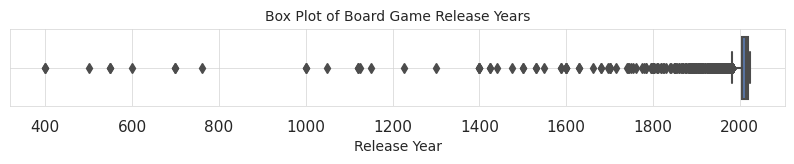

In [7]:
# Load the CSV file
df1 = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create a box plot of release years
sns.set(style="whitegrid")
plt.figure(figsize=(10, 1)) 
sns.boxplot(x=df1['Release Year'])

# Add title, formatting, and labels
plt.title('Box Plot of Board Game Release Years', fontsize=10)
plt.xlabel('Release Year', fontsize =10)
plt.grid(True, color='lightgrey', linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(0.5)

# Show plot
plt.show()